# Flux Spectra Are Confusing

And I don't understand them at all, so let's play around for a while.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")
sns.set_palette("colorblind")

import sherpa.astro.ui as ui

import numpy as np
from clarsach.spectrum import XSpectrum


failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


Let's first make a simple constant model to use:

In [2]:
def const(energy, c):
    return np.ones_like(energy)*c

def const_integrated(energ_lo, energ_hi, c):
    return c*(energ_hi - energ_lo)

Okay, let's first load the data in sherpa:

In [3]:
ui.load_data(id="p1", filename="fake_heg_p1.pha")

statistical errors were found in file 'fake_heg_p1.pha' 
but not used; to use them, re-read with use_errors=True
read ARF file arfs/aciss_heg1_cy19.garf
read RMF file rmfs/aciss_heg1_cy19.grmf


In [4]:
d = ui.get_data("p1")

In [5]:
exposure = d.exposure

In [6]:
# conversion factor from keV to angstrom
c = 12.3984191

# This is the data in angstrom
bin_lo = d.bin_lo
bin_hi = d.bin_hi
bin_mid = bin_lo + (bin_hi - bin_lo) / 2.0

counts = d.counts



Now we can calculate the photon flux using sherpa:

In [7]:
ui.set_source("p1", model=ui.polynom1d.truespec)

In [8]:
photonflux = ui.get_ratio_plot("p1").y

<IPython.core.display.Javascript object>


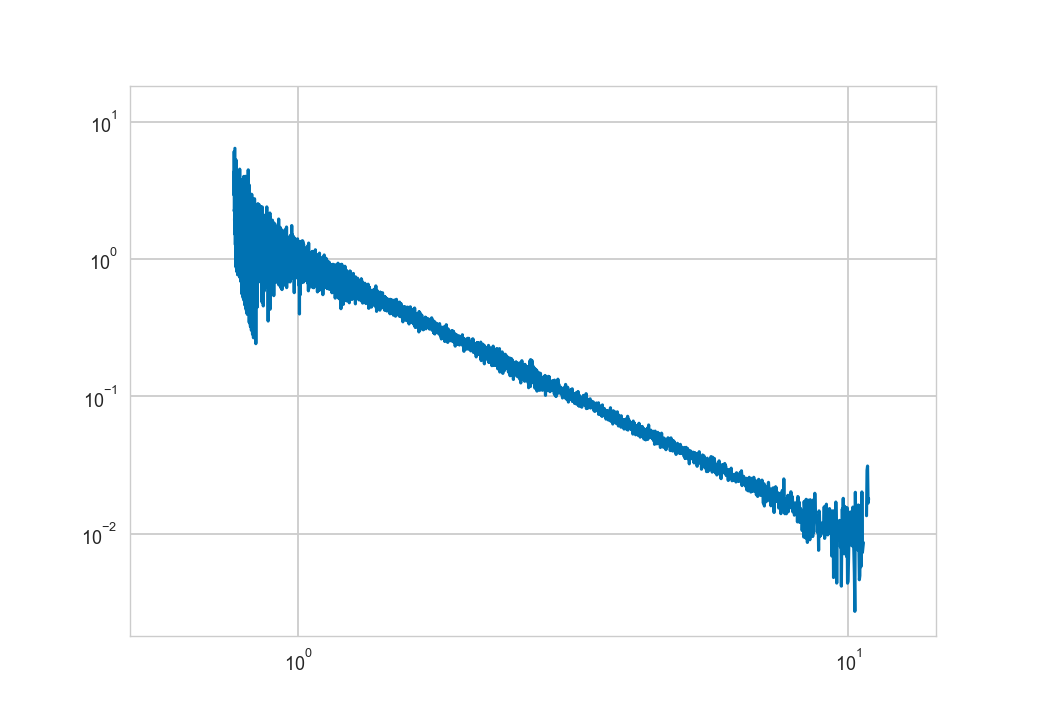

In [9]:
plt.figure()
#plt.plot(bin_mid, counts, label="data")
plt.loglog(bin_mid, photonflux)

Now let's load our data into an `XSpectrum` object and define our own function for making flux spectra:

In [10]:
datadir = "../data/"

In [11]:
spec = XSpectrum(datadir+"fake_heg_p1.pha")

In [12]:
def make_flux_spectra(spec, counts=None, with_energies=True):
    """
    Making flux spectra out of a a single data set.
    
    Parameters
    ----------
    spec : clarsach.XSpectrum object
        An XSpectrum object containing the X-ray spectrum

    counts : iterable
        An array with counts to be converted to the flux 
        If this is None, use the `counts` attribute of the `spec` 
        object. 
    
    Returns
    -------
    flux_spectrum:
        The flux spectrum
        
    """
    
    # make a flat spectrum so that I can integrate 
    # ARF and RMF only
    if with_energies:
        flat_model = np.ones_like(spec.counts) * (spec.rmf.energ_hi - spec.rmf.energ_lo)
    else:
        flat_model = np.ones_like(spec.counts)
        
    # now apply ARF to the flat model
    m_arf = spec.arf.apply_arf(flat_model)*spec.exposure
    
    # apply RMF to the flat model
    m_rmf = spec.rmf.apply_rmf(m_arf)
    
    # divide the observed counts by the flat model with the ARF/RMF applied
    if counts is None:
        flux_spec = spec.counts/m_rmf#/spec.exposure
    else:
        flux_spec = counts/m_rmf#/spec.exposure

 
    return flux_spec
    

In [13]:
my_flux1 = make_flux_spectra(spec, with_energies=False)

In [14]:
my_flux2 = make_flux_spectra(spec, with_energies=True)

And using the function in Clarsach:

In [15]:
from clarsach.spectrum import calculate_flux_spectra

In [16]:
my_flux3 = calculate_flux_spectra(spec)

<IPython.core.display.Javascript object>


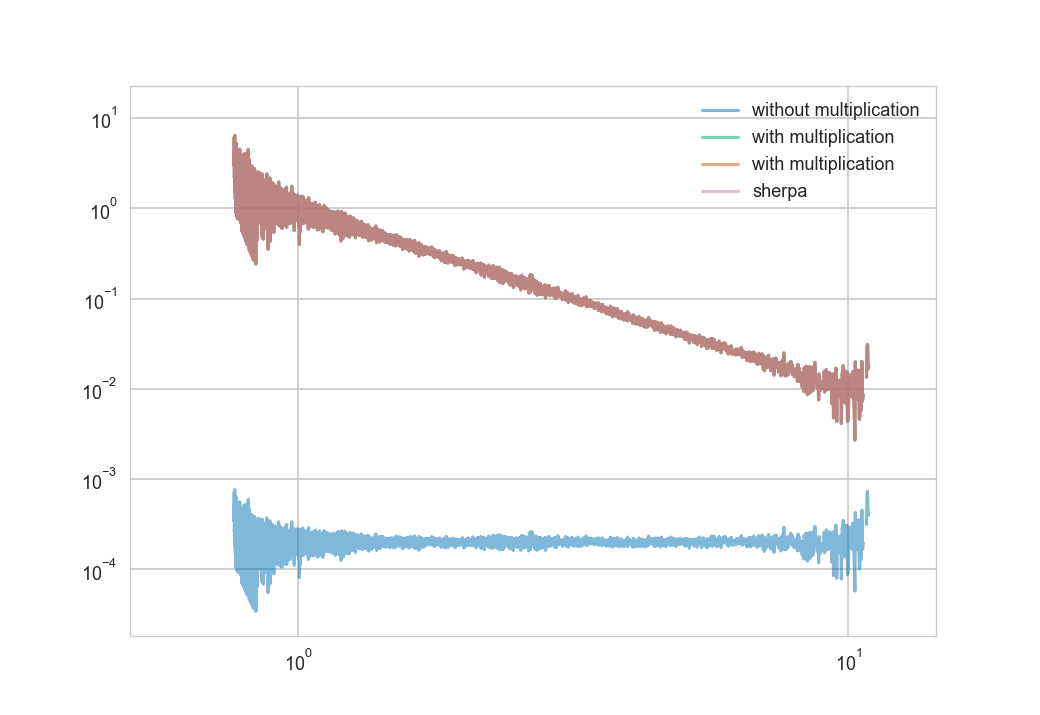

In [17]:
plt.figure()
#plt.loglog(bin_mid, photonflux)
plt.loglog(spec.bin_mid, my_flux1, label="without multiplication", alpha=0.5)
plt.loglog(spec.bin_mid, my_flux2, label="with multiplication", alpha=0.5)
plt.loglog(spec.bin_mid, my_flux3, label="with multiplication", alpha=0.5)

plt.plot(spec.bin_mid, photonflux, label="sherpa", alpha=0.5)
plt.legend()